# 导入包，确定设备

导入包

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

D:\AAA_SoftWare\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


确认当前代码运行在什么版本的 Python 和第三方库上

In [3]:
print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=14, micro=2, releaselevel='final', serial=0)
matplotlib 3.10.8
numpy 2.4.1
pandas 3.0.0
sklearn 1.8.0
torch 2.10.0+cu130


选择设备，用GPU或者CPU

In [4]:
print(torch.cuda.is_available())
#输出cuda驱动有没有，英伟达显卡有没有

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#三元运算符，如果torch.cuda.is_available()为true，就将设备设置为cuda0，表示第一块显卡，没有则是cpu

print(device)
#输出设备

True
cuda:0


# 数据准备

导入包
torchvision中的datasets是计算机视觉领域常用数据集
torchvision.transforms.ToTensor：模型不能直接处理文字图片，需要将数据转换为张量
将image或者ndarray转换为pytorch的tensor

In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor

图像分类数据集
torchvision 数据集里没有提供训练集和验证集的划分

In [6]:
look_ds = datasets.FashionMNIST(
    root="data",
    download=True,
)
#看数据

train_ds = datasets.FashionMNIST(
    root="data",  # 数据存在哪
    train=True,  # 是要训练集还是测试集
    download=True,  # 没找到就自动下载
    transform=ToTensor()  # 拿出来的材料要怎么加工
)
#用作训练集

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
#用作测试集

In [17]:
print(train_ds)
print('*' * 50)
print(test_ds)
print('*' * 50)
print(f"这个数据集有{len(train_ds.classes)}个类别")
#查看格式
#数据量的多少是数据集本事已经确定好的，60000与10000

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
**************************************************
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
**************************************************
这个数据集有10个类别


# 查看数据集

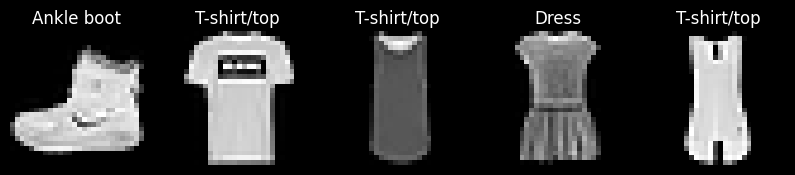

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(5):
    img, label = look_ds[i]
    plt.subplot(1, 5, i + 1)
    # PIL 图片可以直接传给 imshow
    plt.imshow(img, cmap="gray")
    plt.title(look_ds.classes[label])
    plt.axis("off")
plt.show()
#批量查看原数据

如果是对于train_ds，由于transform=ToTensor()，就不能使用上方看原数据的代码了

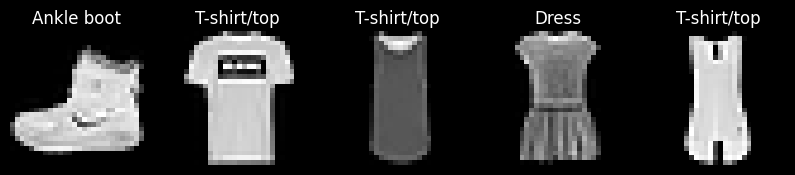

In [9]:
plt.figure(figsize=(10, 5))
for i in range(5):
    img_tensor, label = train_ds[i]  # 此时 img_tensor 是 [1, 28, 28] 的 Tensor
    plt.subplot(1, 5, i + 1)
    # --- 核心修改点 ---
    # 使用 squeeze() 去掉大小为 1 的维度，变成 [28, 28]
    view_img = img_tensor.squeeze().numpy()
    plt.imshow(view_img, cmap="gray")
    # ------------------
    plt.title(train_ds.classes[label])
    plt.axis("off")
plt.show()
# 改进后的代码，可以将tensor可视化
# squeeze()（英文翻译：挤压）的作用是：去掉大小为 1 的维度，变成 [28, 28]
# numpy()的作用是：将tensor转换为numpy数组,numpy数组可以直接可视化

squeeze()（英文翻译：挤压）的作用是：去掉大小为 1 的维度，变成 [28, 28]

torch.Size([1, 28, 28])
torch.Size([28, 28])
<class 'torch.Tensor'>
<class 'numpy.ndarray'>


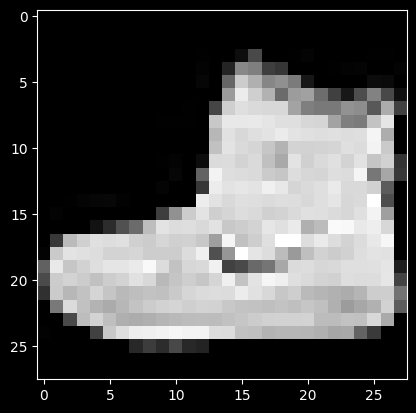

In [10]:
img_test, label_test = train_ds[0]
print(img_test.shape)
print(img_test.squeeze().shape)
print(type(img_test.squeeze()))
print(type(img_test.squeeze().numpy()))
img = img_test.squeeze().numpy()
plt.imshow(img, cmap="gray")

# 将数据集送至dataloader


In [11]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)
#dataloader的作用是：将数据集分成多个batch，每个batch包含32个样本
#shuffle=True表示每个epoch都要打乱样本顺序

查看dataloader中的数据是什么样子

In [12]:
for datas, labels in train_loader:
    print(datas.shape)
    print(labels.shape)
    break
print('*' * 50)
print(train_loader.dataset)
print('*' * 50)
print(test_loader.dataset)

torch.Size([64, 1, 28, 28])
torch.Size([64])
**************************************************
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
**************************************************
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


# 定义模型

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()  #继承nn.Module的属性
        self.flatten = nn.Flatten()  #将输入展平为一维向量，为了让后面的全连接层能够处理
        self.linear_relu_stack = nn.Sequential(  # 定义一个顺序容器，将多个层按顺序排列起来
            nn.Linear(28 * 28, 500),  # in_features=784, out_features=300
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  #输入展平为一维向量
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)  #数据流经784->500->300->100->10
        # logits.shape [batch size, 10]
        return logits  #返回原始输出，未经过softmax


model = NeuralNetwork()

# 模型评估函数

In [18]:
from sklearn.metrics import accuracy_score


@torch.no_grad()  #告诉 PyTorch，“接下来的计算不需要记录梯度（Gradient）”，训练时我们需要梯度来更新模型，但评估时不需要。关闭它可以大幅节省显存，并加快计算速度
def evaluating(model, dataloader, loss_fct):  #评估函数，输入模型、数据加载器、损失函数，输出验证集平均损失和准确率
    loss_list = []  # 存每一批次的损失
    pred_list = []  # 存所有预测出来的类别
    label_list = []  # 存所有真实的类别
    for datas, labels in dataloader:  #逐批次（Batch）进行计算
        #datas.shape [batch size, 1, 28, 28]
        #labels.shape [batch size]
        datas = datas.to(device)  # 将输入数据移动到 GPU 上
        labels = labels.to(device)  # 将标签（真实类别）移动到 GPU 上
        # 前向计算
        logits = model(datas)  #得到原始得分,logits.shape是[32, 10]，32行表示有32张图片，10表示一张图片对10个类比的得分
        loss = loss_fct(logits,
                        labels)  # 验证集损失，loss是一个只包含一个元素的 Tensor，内置了softmax函数，通过logits计算出每个样本属于每个类别的概率，再通过labels计算出每个样本的损失
        loss_list.append(loss.item())  # tensor.item() 获取tensor的数值

        preds = logits.argmax(axis=-1)
        '''
        argmax(axis=-1):在 10 个类别的得分中，找到最高分的那个下标（索引）。比如第 3 个数最大，那么预测就是 3（连衣裙）
        axis=-1:表示最后一个维度,因为logits.shape==[32, 10]，所以axis=-1表示对最后一个维度求argmax，即对每个样本的10个类别的概率求argmax，得到最大概率的类别, preds.shape [32]，分别装了32个样本的预测类别
        '''

        pred_list.extend(preds.cpu().numpy().tolist())  # preds是tensor，存在gpu上，cpu()，改存至cpu上，再转numpy，再转list
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)  # 验证集准确率
    return np.mean(loss_list), acc  # 返回验证集平均损失和准确率

# TensorBoard可视化
使用：tensorboard  --logdir="D:\Code\Py_code_2026\2026py\WdExample\DEEPLEARNING\runs"调用

In [ ]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        self.writer = SummaryWriter(log_dir=log_dir,
                                    flush_secs=flush_secs)  # 实例化SummaryWriter, log_dir是log存放路径，flush_secs是每隔多少秒写入磁盘

    #绘制模型结构图
    def draw_model(self, model, input_shape):  #在 TensorBoard 的 "Graphs" 标签页画出神经网络的结构图（就像流程图一样）
        self.writer.add_graph(model, input_to_model=torch.randn(
            input_shape))  # input_shape你需要告诉它输入数据的形状，torch.randn它会造一个假的随机数据，add_graph让这个假数据流过模型，从而记录下数据经过了哪些层，自动生成拓扑图

    #记录多条曲线add_loss_scalars，add_acc_scalars，add_lr_scalars
    def add_loss_scalars(self, step, loss, test_loss):
        self.writer.add_scalars(
            main_tag="training/loss",  #图表的大标题
            tag_scalar_dict={"loss": loss, "test_loss": test_loss},
            # 字典里的键值对决定了图上有几条线，loss是训练集损失，test_loss是测试集损失，把这两条线画在一起，你可以直观地判断模型是否过拟合
            global_step=step,  # 横坐标（X轴），通常代表“步数”或“Epoch”
        )  # 画loss曲线, main_tag是主tag，tag_scalar_dict是子tag，global_step是步数

    def add_acc_scalars(self, step, acc, test_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "test_accuracy": test_acc},
            global_step=step,
        )  # 画acc曲线, main_tag是主tag，tag_scalar_dict是子tag，global_step是步数

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
        )  # 画lr曲线, main_tag是主tag，tag_scalar_dict是子tag，global_step是步数

    def __call__(self, step, **kwargs):
        # add loss,把loss，test_loss取掉，画loss曲线
        # 1. 解析参数：尝试从 kwargs 字典里拿 loss 数据
        loss = kwargs.pop("loss", None)
        test_loss = kwargs.pop("test_loss", None)
        # 2. 智能分发：如果拿到了 loss 数据，就去画 Loss 图
        if loss is not None and test_loss is not None:
            self.add_loss_scalars(step, loss, test_loss)  # 画loss曲线
        # add acc
        acc = kwargs.pop("acc", None)
        test_acc = kwargs.pop("test_acc", None)
        if acc is not None and test_acc is not None:
            self.add_acc_scalars(step, acc, test_acc)  # 画acc曲线
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)  # 画lr曲线


# 保存最好的模型

In [ ]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=500, save_best_only=True):
        self.save_dir = save_dir # 保存路径
        self.save_step = save_step # 保存步数
        self.save_best_only = save_best_only # 是否只保存最好的模型
        self.best_metrics = -1 # 置一个初始的“最高分”。因为准确率通常是 0 到 1 之间的正数，设为 -1 确保第一次保存一定能成功（因为任何正数都大于 -1）

        # mkdir
        if not os.path.exists(self.save_dir): # 如果不存在保存路径，则创建
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0: #每隔save_step步保存一次
            return

        if self.save_best_only:
            assert metric is not None # 必须传入metric
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt")) # 保存最好的模型，覆盖之前的模型，不保存step，只保存state_dict，即模型参数，不保存优化器参数
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt")) # 保存每个step的模型，不覆盖之前的模型，保存step，保存state_dict，即模型参数，不保存优化器参数